<a href="https://colab.research.google.com/github/youngseopark05/cs4243-captcha-recognition-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
from typing import List, Tuple
from tqdm import tqdm

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

Image = np.ndarray
CharacterWithLabel = tuple[Image, str]

In [ ]:
import random

np.random.seed(1)
random.seed(1)

In [ ]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ..

/


In [ ]:
SOURCE_DIR = '/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled'
BLACK_LINES_REMOVED_DIR = '/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/black_lines_removed'
BLACK_LINES_REMOVED_SUFFIX = '_cleaned'
CONTRAST_ENHANCED_DIR = '/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/contrast_enhanced'
THICKNESS_ENHANCED_DIR = '/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/thickness_enhanced'

## 1.0 Remove Black Lines

In [ ]:
def remove_black_lines(img_path, save=True, output_dir=BLACK_LINES_REMOVED_DIR, suffix=BLACK_LINES_REMOVED_SUFFIX) -> Image:
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read {img_path}")
        return None

    # Define black pixel mask
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([8, 8, 8])
    mask = cv2.inRange(img, lower_black, upper_black)

    # Inpaint to reconstruct the colors
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    cleaned = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Save to cleaned folder
    if save:
        fname = os.path.basename(img_path)
        name, ext = os.path.splitext(fname)
        save_path = os.path.join(output_dir, f"{name}{suffix}{ext}")
        cv2.imwrite(save_path, cleaned)
    return cleaned


def remove_black_lines_from_dir(input_dir: str = SOURCE_DIR) -> List[Image]:
  os.makedirs(BLACK_LINES_REMOVED_DIR, exist_ok=True)
  cleaned_images = []
  for image_path in glob.glob(os.path.join(input_dir, "*.png")):
    print(image_path)
    cleaned = remove_black_lines(image_path)
    print(cleaned.shape)
    cleaned_images.append(cleaned)
  return cleaned_images



## 2.0 Contrast Enhancement

In [ ]:
def enhance_contrast_ycrcb(img_path, output_dir, save=True):
    """Enhance image contrast using histogram equalization on Y (luminance) channel."""

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read {img_path}")
        return None

    # Convert directly from BGR to YCrCb
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    # Equalize Y (luminance) channel
    y_eq = cv2.equalizeHist(y)

    # Merge and convert back to BGR
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    enhanced = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

    # Save result if needed
    if save:
        # os.makedirs(output_dir, exist_ok=True)
        fname = os.path.basename(img_path)
        name, ext = os.path.splitext(fname)
        save_path = os.path.join(output_dir, f"{name}_enhanced{ext}")
        cv2.imwrite(save_path, enhanced)
        print(f"✅ Saved enhanced image to: {save_path}")

    return img, enhanced


def enhance_contrast_dir_input(input_dir = BLACK_LINES_REMOVED_DIR, output_dir = CONTRAST_ENHANCED_DIR, save=True):
  if save:
    os.makedirs(output_dir, exist_ok=True)

  for image_path in glob.glob(os.path.join(input_dir, "*.png")):
    enhance_contrast_ycrcb(image_path, output_dir, save=True)



## Segment into characters by colour clustering

In [ ]:
def merge_duplicates(char_info, iou_threshold=0.6):
    merged = []
    used = [False] * len(char_info)

    for i, info_i in enumerate(char_info):
        if used[i]:
            continue

        x1_i, y1_i, x2_i, y2_i = info_i['bbox']
        area_i = (x2_i - x1_i) * (y2_i - y1_i)
        merged_info = info_i

        for j, info_j in enumerate(char_info):
            if i == j or used[j]:
                continue
            x1_j, y1_j, x2_j, y2_j = info_j['bbox']
            area_j = (x2_j - x1_j) * (y2_j - y1_j)

            # intersection
            inter_x1, inter_y1 = max(x1_i, x1_j), max(y1_i, y1_j)
            inter_x2, inter_y2 = min(x2_i, x2_j), min(y2_i, y2_j)
            inter_w = max(0, inter_x2 - inter_x1)
            inter_h = max(0, inter_y2 - inter_y1)
            inter_area = inter_w * inter_h

            iou = inter_area / float(area_i + area_j - inter_area + 1e-5)
            if iou > iou_threshold:
                used[j] = True  # mark duplicate as used

        used[i] = True
        merged.append(merged_info)

    return merged

def split_overlap(mask):
    """Try vertical projection first, else fallback to watershed."""
    proj = np.sum(mask, axis=0)
    proj_smooth = cv2.GaussianBlur(proj, (7, 1), 0)

    valleys = np.where(proj_smooth < 0.3 * np.max(proj_smooth))[0]
    if len(valleys) > 0:
        split = valleys[len(valleys) // 2]
        return [mask[:, :split], mask[:, split:]]

    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
    fg = np.uint8(fg)
    unknown = cv2.subtract(mask, fg)
    _, markers = cv2.connectedComponents(fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    imgc = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(imgc, markers)
    pieces = []
    for i in np.unique(markers):
        if i <= 1:
            continue
        pieces.append(np.uint8(markers == i) * 255)
    return pieces

def segment_characters_color_overlap(image: Image, labels_string: str) -> List[CharacterWithLabel]:
    """
    Segment individual characters using color clustering + connected components,
    with overlap splitting and duplicate cleanup.
    Returns a list of (cropped_character_image, label) pairs.
    """
    if len(image.shape) != 3:
        raise ValueError("Expected a color image (BGR).")

    k = len(labels_string)

    # K-means clustering in HSV space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    pixels = hsv.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, lbls, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmap = lbls.reshape(image.shape[:2])
    bg_color = np.median(hsv.reshape(-1, 3), axis=0)

    char_info = []
    all_widths, all_areas = [], []

    # cluster statistics
    for cid in np.unique(segmap):
        cluster_color = centers[cid]
        if np.linalg.norm(cluster_color - bg_color) < 25:
            continue

        mask = (segmap == cid).astype(np.uint8) * 255
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        n, _, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

        for i in range(1, n):
            x, y, w, h, area = stats[i]
            if area > 50 and w > 8 and h > 8:
                all_widths.append(w)
                all_areas.append(area)

    if len(all_widths) == 0:
        return []

    median_w = np.median(all_widths)
    median_area = np.median(all_areas)

    # bounding boxes
    for cid in np.unique(segmap):
        cluster_color = centers[cid]
        if np.linalg.norm(cluster_color - bg_color) < 25:
            continue

        mask = (segmap == cid).astype(np.uint8) * 255
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        n, _, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

        for i in range(1, n):
            x, y, w, h, area = stats[i]
            if area < 50 or w < 8 or h < 8:
                continue

            # overlapping blobs
            if w > 1.6 * median_w or area > 1.6 * median_area:
                submasks = split_overlap(mask[y:y+h, x:x+w])
            else:
                submasks = [mask[y:y+h, x:x+w]]

            for sm in submasks:
                # Calculate bounding box for each submask within the original region
                # Find non-zero pixels in the submask
                coords = np.where(sm > 0)
                if len(coords[0]) == 0:
                    continue  # Skip empty submasks

                # Get bounding box relative to the submask (local coordinates)
                sm_y_min, sm_x_min = coords[0].min(), coords[1].min()
                sm_y_max, sm_x_max = coords[0].max() + 1, coords[1].max() + 1

                # Convert to global image coordinates
                bbox_x1 = x + sm_x_min
                bbox_y1 = y + sm_y_min
                bbox_x2 = x + sm_x_max
                bbox_y2 = y + sm_y_max

                char_info.append({
                    "bbox": (bbox_x1, bbox_y1, bbox_x2, bbox_y2),
                    "mask": sm,
                    "cluster": int(cid)
                })

    # merge duplicates and sort left-to-right
    char_info = merge_duplicates(char_info)
    char_info.sort(key=lambda ci: ci["bbox"][0])

    if len(char_info) > len(labels_string):
        char_info = char_info[:len(labels_string)]
    elif len(char_info) < len(labels_string):
        labels_string = labels_string[:len(char_info)]

    labeled_characters: List[CharacterWithLabel] = []
    for info, label in zip(char_info, labels_string):
        x1, y1, x2, y2 = info["bbox"]
        cropped = image[y1:y2, x1:x2]
        labeled_characters.append((cropped, label))

    return labeled_characters


def segment_into_characters(image_dir: str = CONTRAST_ENHANCED_DIR) -> List[CharacterWithLabel]:
  segmented_character_with_labels: List[CharacterWithLabel] = []
  for filename in os.listdir(image_dir):
    print(filename)
    if not filename.endswith(".png"):
      continue
    print("passed")
    name, ext = os.path.splitext(filename)
    labels_string = name.split("-")[0]
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is None:
      print(f"⚠️ Could not read {os.path.join(image_dir, filename)}")
      continue
    segmented = segment_characters_color_overlap(img, labels_string)
    segmented_character_with_labels.extend(segmented)
  return segmented_character_with_labels

In [ ]:
# def segment_characters_color_overlap(image: np.ndarray) -> list[dict]:
#     """
#     Returns a list of dicts: { 'bbox': (x1,y1,x2,y2), 'mask': np.uint8[...] }
#     No dependence on label length.
#     """
#     if image.ndim != 3:
#         raise ValueError("Expected BGR image")

#     H, W = image.shape[:2]

#     # --- 1) Color + spatial features, no fixed K ---
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
#     yy, xx = np.mgrid[0:H, 0:W]

#     # Create a mask to find all non-white pixels
#     # (S > 10 and V > 10) is a good proxy for "not black or white"
#     s_channel = hsv[..., 1]
#     v_channel = hsv[..., 2]
#     # Adjust thresholds as needed
#     fg_mask = (s_channel > 25) & (v_channel > 25)
#     fg_mask_flat = fg_mask.ravel()

#     feats = np.stack([
#         hsv[...,0] / 180.0,
#         hsv[...,1] / 255.0,
#         hsv[...,2] / 255.0,
#         xx / float(W),
#         yy / float(H)
#     ], axis=-1).reshape(-1, 5)

#     # Subsample to speed up clustering if needed
#     # idx = np.random.choice(feats.shape[0], size=min(15000, feats.shape[0]), replace=False)
#     fg_indices = np.where(fg_mask_flat > 0)[0]
#     if fg_indices.size == 0:
#         print("Warning: No foreground pixels found.")
#         return [] # No characters

#     sample_size = min(15000, fg_indices.size)
#     idx = np.random.choice(fg_indices, size=sample_size, replace=False)

#     sample = feats[idx]

#     # DBSCAN in feature space; tune eps/min_samples to your images
#     from sklearn.cluster import DBSCAN
#     # eps=0.1 allows for a larger color/spatial neighborhood
#     # min_samples=15 is more reasonable for sparse characters
#     db = DBSCAN(eps=0.1, min_samples=15).fit(sample)

#     # Map labels back to full image by nearest neighbor on features (simple + fast)
#     from sklearn.neighbors import KNeighborsClassifier
#     knn = KNeighborsClassifier(n_neighbors=3)
#     knn.fit(sample, db.labels_)
#     # labels = knn.predict(feats).reshape(H, W)

#     labels_flat = knn.predict(feats)
#     # Force all background pixels (from our mask) to be noise
#     labels_flat[fg_mask_flat == 0] = -1
#     labels = labels_flat.reshape(H, W)

#     # Remove noise label (-1)
#     valid_lbls = [l for l in np.unique(labels) if l >= 0]
#     char_info = []
#     widths, heights, areas = [], [], []

#     # --- 2) CC per cluster to get blobs ---
#     kernel = np.ones((3,3), np.uint8)
#     for cid in valid_lbls:
#         mask = np.uint8(labels == cid) * 255
#         mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#         n, _, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
#         for i in range(1, n):
#             x, y, w, h, a = stats[i]
#             if a < 40 or min(w, h) < 6:
#                 continue
#             widths.append(w); heights.append(h); areas.append(a)

#     if not widths:
#         return []

#     med_w, med_h, med_a = np.median(widths), np.median(heights), np.median(areas)

#     # --- 3) Build candidate boxes (with over-seg on wide blobs) ---
#     def split_overlap(mask_roi):
#         proj = np.sum(mask_roi > 0, axis=0).astype(np.float32)
#         if proj.max() == 0:
#             return []
#         sm = cv2.GaussianBlur(proj, (7,1), 0)
#         valleys = np.where(sm < 0.35 * sm.max())[0]
#         if len(valleys) > 0:
#             split = int(np.median(valleys))
#             return [mask_roi[:, :split], mask_roi[:, split:]]
#         # watershed fallback
#         dist = cv2.distanceTransform((mask_roi>0).astype(np.uint8), cv2.DIST_L2, 5)
#         _, fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
#         fg = np.uint8(fg)
#         unknown = np.uint8(mask_roi) - fg
#         _, markers = cv2.connectedComponents(fg)
#         markers = markers + 1
#         markers[unknown > 0] = 0
#         rgb = cv2.cvtColor(np.uint8(mask_roi>0)*255, cv2.COLOR_GRAY2BGR)
#         markers = cv2.watershed(rgb, markers)
#         pieces = []
#         for m in np.unique(markers):
#             if m <= 1: continue
#             pieces.append(np.uint8(markers == m) * 255)
#         return pieces if pieces else [mask_roi]

#     candidates = []
#     for cid in valid_lbls:
#         mask = np.uint8(labels == cid) * 255
#         n, _, stats, _ = cv2.connectedComponentsWithStats(mask, 8)
#         for i in range(1, n):
#             x, y, w, h, a = stats[i]
#             if a < 40 or min(w,h) < 6:
#                 continue
#             roi = mask[y:y+h, x:x+w]
#             # over-split wide/large blobs
#             subs = split_overlap(roi) if (w > 1.7*med_w or a > 1.7*med_a) else [roi]
#             for sm in subs:
#                 ys, xs = np.where(sm > 0)
#                 if ys.size == 0: continue
#                 x1, y1 = x + xs.min(), y + ys.min()
#                 x2, y2 = x + xs.max() + 1, y + ys.max() + 1
#                 candidates.append({'bbox': (x1,y1,x2,y2), 'mask': sm})

#     # --- 4) Validate candidates (shape/stroke priors) ---
#     def score_candidate(b):
#         x1,y1,x2,y2 = b['bbox']
#         w, h = x2-x1, y2-y1
#         if w <= 0 or h <= 0: return -1e9
#         roi = (b['mask'] > 0).astype(np.uint8)
#         fill = roi.sum() / float(w*h)
#         aspect = w / float(h+1e-6)
#         # quick strokes proxy via distance transform std
#         dist = cv2.distanceTransform(roi, cv2.DIST_L2, 5)
#         sw_std = float(dist[roi>0].std()) if (roi>0).any() else 999
#         ok_size = (0.3*med_h <= h <= 1.5*med_h)
#         ok_aspect = (0.15 <= aspect <= 3.0)
#         ok_fill = (0.08 <= fill <= 0.9)
#         base = 0.0
#         base += 1.0 if ok_size else -1.0
#         base += 0.5 if ok_aspect else -0.5
#         base += 0.5 if ok_fill else -0.5
#         base -= 0.05 * sw_std   # prefer consistent stroke width
#         return base

#     candidates = [c for c in candidates if score_candidate(c) > -0.5]

#     # --- 5) NMS / de-dup + thin-merge of tiny neighbors ---
#     candidates = merge_duplicates(candidates, iou_threshold=0.6)
#     candidates.sort(key=lambda c: c['bbox'][0])

#     # neighbor merge for obvious over-splits
#     merged = []
#     i = 0
#     while i < len(candidates):
#         cur = candidates[i]
#         if i+1 < len(candidates):
#             x1,y1,x2,y2 = cur['bbox']
#             nx1,ny1,nx2,ny2 = candidates[i+1]['bbox']
#             w, nw = x2-x1, nx2-nx1
#             gap = max(0, nx1 - x2)
#             if (w < 0.6*med_w or nw < 0.6*med_w) and gap < 0.08*W:
#                 # merge
#                 mx1, my1 = min(x1,nx1), min(y1,ny1)
#                 mx2, my2 = max(x2,nx2), max(y2,ny2)
#                 cur = {'bbox': (mx1,my1,mx2,my2), 'mask': None}
#                 i += 2
#                 merged.append(cur)
#                 continue
#         merged.append(cur); i += 1

#     return merged

# # def segment_into_characters(image_dir: str) -> list[np.ndarray]:
# #     crops = []
# #     for fn in os.listdir(image_dir)[:5]:
# #         if not fn.endswith(".png"):
# #             continue
# #         img = cv2.imread(os.path.join(image_dir, fn))
# #         if img is None:
# #             continue
# #         char_boxes = segment_characters_color_overlap(img)
# #         for info in char_boxes:
# #             x1,y1,x2,y2 = info['bbox']
# #             crops.append(img[y1:y2, x1:x2])
# #     return crops

# import os
# import cv2
# import numpy as np

# # (You'll need your 'segment_characters_color_overlap' function defined somewhere above this)

# def segment_into_characters(image_dir: str) -> list[dict]:
#     """
#     Finds characters in images and groups them by their source image.

#     RETURNS:
#     A list of dictionaries, where each dict has:
#     {
#         'filename': str,
#         'original_image': np.ndarray (the full BGR image),
#         'crops': list[np.ndarray] (list of BGR crops)
#     }
#     """

#     all_results = [] # This will hold our dictionaries

#     for fn in os.listdir(image_dir):
#         if not fn.endswith(".png"):
#             continue

#         img_path = os.path.join(image_dir, fn)
#         img = cv2.imread(img_path)
#         if img is None:
#             continue

#         char_boxes = segment_characters_color_overlap(img)

#         # Create a temporary list to hold crops *only* for this image
#         crops_for_this_image = []
#         for info in char_boxes:
#             x1,y1,x2,y2 = info['bbox']
#             crop = img[y1:y2, x1:x2]
#             crops_for_this_image.append(crop)

#         # Add a dictionary to the main results list
#         all_results.append({
#             'filename': fn,
#             'original_image': img,
#             'crops': crops_for_this_image
#         })

#     return all_results
# """

## 4.1 Transform thin characters

In [ ]:
def transform_resolve_thin_characters(characters: List[CharacterWithLabel], is_save: bool = True):
  transformed = []
  output_dir = THICKNESS_ENHANCED_DIR
  if is_save:
      os.makedirs(output_dir, exist_ok=True) # Create output directory once

  for idx, (img, label) in enumerate(characters):
    if img is None:
      print(f"Warning: Skipping invalid image for label '{label}'")
      continue

    # --- Step 1: CLAHE on L channel (contrast enhancement) ---
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # --- Step 2: Contrast stretching (deepens dark text without crushing highlights) ---
    min_val, max_val = np.min(enhanced), np.max(enhanced)
    stretched = cv2.convertScaleAbs(enhanced, alpha=255.0/(max_val - min_val), beta=-255.0*min_val/(max_val - min_val))

    # --- Step 3: Slight sharpening to improve text edge clarity ---
    blur = cv2.GaussianBlur(stretched, (0, 0), 1.2)
    sharpened = cv2.addWeighted(stretched, 1.4, blur, -0.4, 0)

    # --- Step 4: Subtle thickening (morphology only on dark regions) ---
    gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)
    _, mask_dark = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((2, 2), np.uint8)
    mask_dilated = cv2.dilate(mask_dark, kernel, iterations=1)
    mask_dilated = cv2.GaussianBlur(mask_dilated, (3, 3), 0)
    mask_dilated = mask_dilated.astype(float) / 255.0

    # Blend thickened regions into sharpened image
    thickened = sharpened.astype(float)
    for c in range(3):
        thickened[..., c] = thickened[..., c] * (1 - 0.15 * mask_dilated)  # darken dark strokes slightly

    thickened = np.clip(thickened, 0, 255).astype(np.uint8)
    transformed.append((thickened, label))

    # Save result if needed
    if is_save:
        save_path = os.path.join(output_dir, f"{idx:05d}_{label}.png")
        cv2.imwrite(save_path, thickened)
        # print(f"✅ Saved enhanced image to: {save_path}")

  return transformed



## 4.2 Deskew characters

In [ ]:

# ---------------------------------------------------------------
# PCA-based angle estimation (improved)
# ---------------------------------------------------------------
def estimate_angle_pca(mask: Image) -> float:
    """Estimate skew angle using PCA on character pixels."""
    mask_binary = (mask > 0).astype(np.uint8)
    # Invert if background is dark
    if np.mean(mask_binary) > 127:
        mask_binary = cv2.bitwise_not(mask_binary)

    coords = np.column_stack(np.where(mask_binary > 0))
    if len(coords) < 10:
        return 0.0

    mean, eigenvectors = cv2.PCACompute(coords.astype(np.float32), mean=None)
    if eigenvectors is None or len(eigenvectors) == 0:
        return 0.0

    v = eigenvectors[0]
    angle = np.degrees(np.arctan2(v[1], v[0]))

    # Normalize angle to [-45, 45] range
    if angle < -45:
        angle += 90
    elif angle > 45:
        angle -= 90

    return angle


# ---------------------------------------------------------------
# Projection-based angle estimation (alternative method)
# ---------------------------------------------------------------
def estimate_angle_projection(mask: Image) -> float:
    """Estimate angle using horizontal projection profile variance."""
    mask_binary = (mask > 0).astype(np.uint8)
    if np.mean(mask_binary) > 127:
        mask_binary = cv2.bitwise_not(mask_binary)

    h, w = mask_binary.shape
    if h < 10 or w < 10:
        return 0.0

    best_angle = 0.0
    max_variance = 0

    # Coarse search first (every 5 degrees)
    for angle in range(-30, 31, 5):
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(mask_binary, M, (w, h), borderValue=0)
        projection = np.sum(rotated, axis=1)
        variance = np.var(projection)

        if variance > max_variance:
            max_variance = variance
            best_angle = float(angle)

    # Fine search around best angle (every 1 degree)
    for angle in range(int(best_angle) - 4, int(best_angle) + 5, 1):
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(mask_binary, M, (w, h), borderValue=0)
        projection = np.sum(rotated, axis=1)
        variance = np.var(projection)

        if variance > max_variance:
            max_variance = variance
            best_angle = float(angle)

    return best_angle


# ---------------------------------------------------------------
# Improved deskew decision logic
# ---------------------------------------------------------------
def should_deskew(mask: Image, angle_threshold: float = 2.0, debug: bool = False) -> Tuple[bool, float]:
    """Determine if character should be deskewed."""
    angle_pca = estimate_angle_pca(mask)

    # If PCA gives unreliable result (0 or very small), try projection method
    if abs(angle_pca) < 1.0:
        angle_proj = estimate_angle_projection(mask)
        if abs(angle_proj) > 1.0:
            angle = angle_proj
        else:
            angle = angle_pca
    else:
        angle = angle_pca

    if debug:
        print(f"  Detected angle: {angle:.1f}°")

    # More lenient threshold - deskew if angle > threshold degrees
    if abs(angle) < angle_threshold:
        if debug:
            print(f"  Decision: NO DESKEW (angle too small)")
        return False, angle

    if debug:
        print(f"  Decision: DESKEW")
    return True, angle


# ---------------------------------------------------------------
# Apply rotation with proper border handling
# ---------------------------------------------------------------
def deskew_character(image: Image, mask: Image, debug: bool = False) -> Tuple[Image, float]:
    """Deskew a character image."""
    should_rotate, angle = should_deskew(mask, debug=debug)

    if not should_rotate or abs(angle) < 1.0:
        return image, 0.0

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Calculate rotation matrix
    rot_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)

    # Calculate new dimensions to avoid clipping
    cos = np.abs(rot_matrix[0, 0])
    sin = np.abs(rot_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix for new center
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]

    # Set border color based on image type
    if len(image.shape) == 3:
        border_color = (255, 255, 255)  # White for BGR
    else:
        border_color = 255  # White for grayscale

    # Rotate with white background
    rotated = cv2.warpAffine(image, rot_matrix, (new_w, new_h),
                            flags=cv2.INTER_CUBIC, borderValue=border_color)

    # Crop to remove white borders by finding bounding box of content
    if len(rotated.shape) == 3:
        gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    else:
        gray = rotated

    # Find non-white regions
    _, binary = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
    coords = np.column_stack(np.where(binary > 0))

    if len(coords) > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        # Add small padding
        padding = 2
        y_min = max(0, y_min - padding)
        x_min = max(0, x_min - padding)
        y_max = min(rotated.shape[0], y_max + padding + 1)
        x_max = min(rotated.shape[1], x_max + padding + 1)

        rotated = rotated[y_min:y_max, x_min:x_max]

    return rotated, angle



def deskew_characters(characters_with_labels: List[CharacterWithLabel], debug: bool = False, visualize: bool = False) -> List[CharacterWithLabel]:
    deskewed: List[CharacterWithLabel] = []

    for idx, (char_img, label) in enumerate(characters_with_labels):
        gray = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY) if len(char_img.shape) == 3 else char_img
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        if debug:
            print(f"\nCharacter {idx + 1} ('{label}'):")

        rotated, angle = deskew_character(char_img, mask, debug=debug)
        deskewed.append((rotated, label))

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            axes[0].imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
            axes[0].set_title(f"Before '{label}'")
            axes[0].axis("off")
            axes[1].imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f"After ({angle:.1f}°)")
            axes[1].axis("off")
            plt.tight_layout()
            plt.show()

    return deskewed

# 4.3 Smoothen edges, random rotate, random zoom, add gaussian noise

In [ ]:
SMOOTHENED_DIR = "/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/outputs/smoothed_characters"
ROTATED_DIR = "/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/outputs/rotated_characters"
ZOOMED_DIR = "/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/outputs/zoomed_characters"
NOISED_DIR = "/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/outputs/noised_characters"

def transform_smoothen_edges(characters: List[CharacterWithLabel], is_save: bool = True):
    transformed = []
    output_dir = SMOOTHENED_DIR
    if is_save:
        os.makedirs(output_dir, exist_ok=True)

    for idx, (img, label) in enumerate(characters):
        if img is None:
            print(f"⚠️ Warning: Skipping invalid image for label '{label}'")
            continue

        # --- Step 1: Edge-preserving smoothing ---
        # This keeps color edges sharp while smoothing inside regions
        smoothed = cv2.edgePreservingFilter(img, flags=1, sigma_s=40, sigma_r=0.3)

        # --- Step 2: Optional mild bilateral smoothing to further refine edges ---
        smoothed = cv2.bilateralFilter(smoothed, d=7, sigmaColor=50, sigmaSpace=50)

        # --- Step 3: Optional gentle Gaussian blur to remove remaining roughness ---
        smoothed = cv2.GaussianBlur(smoothed, (3, 3), 0.5)

        transformed.append((smoothed, label))

        # --- Step 4: Save result if needed ---
        if is_save:
            save_path = os.path.join(output_dir, f"{idx:05d}_{label}.png")
            cv2.imwrite(save_path, smoothed)

    return transformed

def transform_random_rotate(characters: List[CharacterWithLabel], is_save: bool = True):
    transformed = []
    output_dir = ROTATED_DIR
    if is_save:
        os.makedirs(output_dir, exist_ok=True)

    for idx, (img, label) in enumerate(characters):
        if img is None:
            print(f"Warning: Skipping invalid image for label '{label}'")
            continue

        h, w = img.shape[:2]

        # --- Step 1: Randomly choose a rotation angle between -20° and +20° ---
        angle = random.uniform(-20, 20)

        # --- Step 2: Compute rotation matrix around the image center ---
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # --- Step 3: Apply rotation using affine transform ---
        # Use border mode to fill outside regions smoothly (instead of black)
        rotated = cv2.warpAffine(
            img,
            M,
            (w, h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REPLICATE
        )

        transformed.append((rotated, label))

        # --- Step 4: Save result if needed ---
        if is_save:
            save_path = os.path.join(output_dir, f"{idx:05d}_{label}.png")
            cv2.imwrite(save_path, rotated)

    return transformed

MAX_ZOOM_OUT_FACTOR = 0.8
MAX_ZOOM_IN_FACTOR = 1.2
def transform_random_zoom(characters: List[CharacterWithLabel], is_save: bool = True):
    transformed = []
    output_dir = ZOOMED_DIR
    if is_save:
        os.makedirs(output_dir, exist_ok=True)

    for idx, (img, label) in enumerate(characters):
        if img is None:
            print(f"Warning: Skipping invalid image for label '{label}'")
            continue

        h, w = img.shape[:2]

        # --- Step 1: Choose random zoom factor (e.g., between 0.9x and 1.1x) ---
        zoom_factor = random.uniform(MAX_ZOOM_OUT_FACTOR, MAX_ZOOM_IN_FACTOR)

        # --- Step 2: Compute new size after zoom ---
        new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # --- Step 3: Crop or pad to restore original size ---
        if zoom_factor < 1.0:
            # Zoomed out → need to pad
            pad_w = (w - new_w) // 2
            pad_h = (h - new_h) // 2
            zoomed = cv2.copyMakeBorder(
                resized,
                pad_h,
                h - new_h - pad_h,
                pad_w,
                w - new_w - pad_w,
                borderType=cv2.BORDER_REPLICATE
            )
        else:
            # Zoomed in → need to crop
            start_x = (new_w - w) // 2
            start_y = (new_h - h) // 2
            zoomed = resized[start_y:start_y + h, start_x:start_x + w]

        transformed.append((zoomed, label))

        # --- Step 4: Save result if needed ---
        if is_save:
            save_path = os.path.join(output_dir, f"{idx:05d}_{label}.png")
            cv2.imwrite(save_path, zoomed)

    return transformed

def transform_add_gaussian_noise(characters: List[CharacterWithLabel], is_save: bool = True):
    transformed = []
    output_dir = NOISED_DIR
    if is_save:
        os.makedirs(output_dir, exist_ok=True)

    for idx, (img, label) in enumerate(characters):
        if img is None:
            print(f"Warning: Skipping invalid image for label '{label}'")
            continue

        # --- Step 1: Normalize image to float32 for noise addition ---
        img_float = img.astype(np.float32) / 255.0

        # --- Step 2: Generate Gaussian noise ---
        # mean = 0, stddev between 0.01 and 0.03 (light noise)
        noise_std = random.uniform(0.01, 0.03)
        noise = np.random.normal(0, noise_std, img_float.shape).astype(np.float32)

        # --- Step 3: Add noise and clip back to valid range ---
        noisy = np.clip(img_float + noise, 0.0, 1.0)

        # --- Step 4: Convert back to uint8 ---
        noisy_uint8 = (noisy * 255).astype(np.uint8)

        transformed.append((noisy_uint8, label))

        # --- Step 5: Save result if needed ---
        if is_save:
            save_path = os.path.join(output_dir, f"{idx:05d}_{label}.png")
            cv2.imwrite(save_path, noisy_uint8)

    return transformed




# 5.0 Combined

In [ ]:
black_lines_removed_captchas = remove_black_lines_from_dir()

enhance_contrast_dir_input(save=True)


In [ ]:
file_list = glob.glob(os.path.join(CONTRAST_ENHANCED_DIR, "*.png"))
num_files = len(file_list)
print(f"There are {num_files} .png files in {CONTRAST_ENHANCED_DIR}")

There are 7887 .png files in /content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/contrast_enhanced


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Found GPU at: {}".format(tf.test.gpu_device_name()))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus)
    try:
        # Set TensorFlow to use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [ ]:
characters_with_enhanced_contrast = segment_into_characters(CONTRAST_ENHANCED_DIR)
# characters = transform_and_increase_dataset(characters)

In [ ]:
# Assuming characters_with_enhanced_contrast is a list of tuples (image, label)
# and the filenames are derived from the original files in CONTRAST_ENHANCED_DIR
# Let's get the original filenames from the directory to be accurate

file_list = glob.glob(os.path.join(CONTRAST_ENHANCED_DIR, "*.png"))
print(len(file_list))
sum_of_lengths = 0
for file_path in file_list:
    fname = os.path.basename(file_path)
    # Split by '-' and take the first part
    parts = fname.split('-')
    if parts:
        prefix = parts[0]
        sum_of_lengths += len(prefix)

print(f"The sum of the lengths of the filename prefixes (before '-') is: {sum_of_lengths}")

7887
The sum of the lengths of the filename prefixes (before '-') is: 47232


In [ ]:
# characters_with_black_removed = segment_into_characters(BLACK_LINES_REMOVED_DIR)

In [ ]:
# characters_with_no_preprocessing = segment_into_characters(SOURCE_DIR)
# characters = add_padding(characters_with_no_preprocessing)
# characters = grayscale(characters)

In [ ]:
characters_with_enhanced_contrast_images = np.load("/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/enhanced_characters_saved/enhanced_characters_images.npy")
characters_with_enhanced_contrast_labels = []
with open("/content/drive/MyDrive/cs4243-project/preprocessing/clean/all_relabelled/enhanced_characters_saved/enhanced_characters_labels.csv") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        characters_with_enhanced_contrast_labels.append(row[0])

characters_with_enhanced_contrast_labels.pop(0)

characters_with_enhanced_contrast = list(zip(characters_with_enhanced_contrast_images, characters_with_enhanced_contrast_labels))
characters_with_enhanced_contrast = [tuple(entry) for entry in characters_with_enhanced_contrast]
characters_with_enhanced_contrast_gray = characters_with_enhanced_contrast
# characters_with_enhanced_contrast_gray = [(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), label) for img, label in characters_with_enhanced_contrast]

In [ ]:
# padded_characters_with_enhanced_contrast_gray = []

# for img, label in characters_with_enhanced_contrast_gray:
#     # Get current dimensions
#     current_h, current_w = img.shape[:2]

#     # Calculate padding for height
#     delta_h = 80 - current_h
#     top = delta_h // 2
#     bottom = delta_h - top

#     # Calculate padding for width
#     delta_w = 80 - current_w
#     left = delta_w // 2
#     right = delta_w - left

#     # Apply padding with white border (255 for grayscale)
#     padded_img = cv2.copyMakeBorder(
#         img,
#         top,
#         bottom,
#         left,
#         right,
#         cv2.BORDER_CONSTANT,
#         value=255
#     )
#     padded_characters_with_enhanced_contrast_gray.append((padded_img, label))

# characters_with_enhanced_contrast_gray = padded_characters_with_enhanced_contrast_gray
# print(f"Padded {len(characters_with_enhanced_contrast_gray)} characters to 80x80 pixels.")

In [ ]:
reshaped_characters_with_enhanced_contrast_gray = []

for img, label in characters_with_enhanced_contrast_gray:
# # # Reshape the 2D image (H, W) to 3D (H, W, 1) to add a channel dimension
  reshaped_img = np.expand_dims(img, axis=-1)
  reshaped_characters_with_enhanced_contrast_gray.append((reshaped_img, label))

print(f"Reshaped {len(reshaped_characters_with_enhanced_contrast_gray)} characters to 80x80x1.")
characters_with_enhanced_contrast_gray = reshaped_characters_with_enhanced_contrast_gray

Reshaped 38313 characters to 80x80x1.


In [ ]:
characters_with_enhanced_contrast_gray[0][0].shape

(80, 80, 1)

In [ ]:
class CNNModel:
  def __init__(self, img_height=80, img_width=80, charset="0123456789abcdefghijklmnopqrstuvwxyz"):
    self.img_height = img_height
    self.img_width = img_width
    self.charset = charset
    self.num_classes = len(charset)
    self.char_to_idx = {char: idx for idx, char in enumerate(charset)}
    self.idx_to_char = {idx: char for idx, char in enumerate(charset)}
    self.model = None

  def build_model(self):
    # Input layer, H=80 x W=80 x 1
    inputs = layers.Input(shape=(self.img_height, self.img_width, 1))

    # Normalize pixel values
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output layer: single character
    outputs = layers.Dense(self.num_classes, activation='softmax')(x)

    # Create the model
    self.model = keras.Model(inputs=inputs, outputs=outputs)
    return self.model

  def compile_model(self, model, learning_rate=0.001):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )
    return model

  def encode_labels(self, labels):
    encoded_labels = [self.char_to_idx[label.lower()] for label in labels]
    return keras.utils.to_categorical(encoded_labels, num_classes=self.num_classes)

  def decode_predictions(self, predictions):
    decoded = []
    pred_indices = np.argmax(predictions, axis=1)

    for idx in pred_indices:
        decoded.append(self.idx_to_char[idx])

    return decoded

  def get_confidence(self, predictions):
    return np.max(predictions, axis=1)

In [ ]:
class CNNModel_Ver2(CNNModel):
  def __init__(self, img_height=80, img_width=80, charset="0123456789abcdefghijklmnopqrstuvwxyz"):
    super().__init__(img_height, img_width, charset)
    self.model = None

  def build_model(self):
    # Input layer, H=80 x W=80 x 1
    inputs = layers.Input(shape=(self.img_height, self.img_width, 1))

    # Normalize pixel values
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer: single character
    outputs = layers.Dense(self.num_classes, activation='softmax')(x)

    # Create the model
    self.model = keras.Model(inputs=inputs, outputs=outputs)
    return self.model

  def compile_model(self, model, learning_rate=0.001):
    lr_scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps= len(characters_with_enhanced_contrast_gray) // 64 * 100) # Batch size, epochs
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )
    return model

In [ ]:
def create_model(img_height=80, img_width=80, charset="0123456789abcdefghijklmnopqrstuvwxyz", learning_rate=0.001):
    cnn = CNNModel(img_height, img_width, charset)
    model = cnn.build_model()
    model = cnn.compile_model(model, learning_rate=learning_rate)
    return model, cnn

In [ ]:
def create_model_ver2(img_height=80, img_width=80, charset="0123456789abcdefghijklmnopqrstuvwxyz", learning_rate=0.001):
    cnn2 = CNNModel_Ver2(img_height, img_width, charset)
    model = cnn2.build_model()
    model = cnn2.compile_model(model, learning_rate=learning_rate)
    return model, cnn

In [ ]:
model, cnn = create_model(learning_rate=0.001)

In [ ]:
model2, cnn2 = create_model_ver2(learning_rate=0.001)

In [ ]:
X_train = [img for img, label in characters_with_enhanced_contrast_gray]
y_train = [label for img, label in characters_with_enhanced_contrast_gray]
y_train_encoded = cnn.encode_labels(y_train)

In [ ]:
X_train = np.array(X_train)
y_train_encoded = np.array(y_train_encoded)

In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=200, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True), keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-7)])

In [ ]:
# Save the trained model
MODEL_SAVE_PATH = '/content/drive/MyDrive/cs4243-project/cnn_character_model.h5'
model.save(MODEL_SAVE_PATH)
# print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Model 2 saved to: {MODEL_VER2_SAVE_PATH}")

Model 2 saved to: /content/drive/MyDrive/cs4243-project/cnn_character_model_ver2.h5


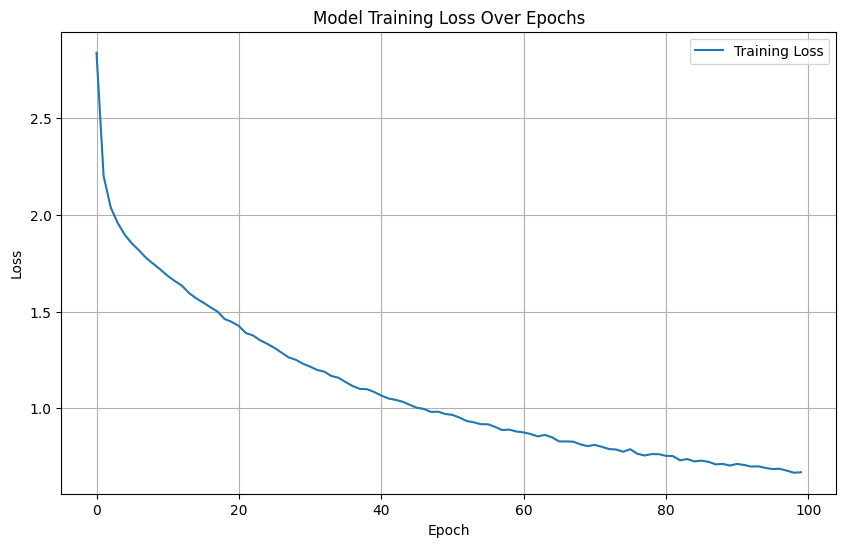

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.title('Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
TEST_DIR = "/content/drive/MyDrive/CS4243/mini_project/test"

# TODO: CHANGE THE remove_black_lines_from_dir() to be able to specify OUTPUT_DIR
# BLACK_LINES_REMOVED_DIR = "/content/drive/MyDrive/cs4243-project/test/black_lines_removed"
# test_black_lines_removed = remove_black_lines_from_dir(TEST_DIR)

# Enhance contrast of test characters
TEST_ENHANCED_CONTRAST_DIR = "/content/drive/MyDrive/cs4243-project/test/enhanced_contrast"
# enhance_contrast_dir_input(input_dir=BLACK_LINES_REMOVED_DIR, output_dir=TEST_ENHANCED_CONTRAST_DIR, save=True)

# Segment test characters TODO: Needs to be k-blind!
test_characters = segment_into_characters(TEST_ENHANCED_CONTRAST_DIR)

# Turn to grayscale
test_characters_gray = [(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), label) for img, label in test_characters]

# Pad to 80x80
padded_test_characters_gray = []
for img, label in test_characters_gray:
    # Get current dimensions
    current_h, current_w = img.shape[:2]

    # Calculate padding for height
    delta_h = 80 - current_h
    top = delta_h // 2
    bottom = delta_h - top

    # Calculate padding for width
    delta_w = 80 - current_w
    left = delta_w // 2
    right = delta_w - left

    # Apply padding with white border (255 for grayscale)
    padded_img = cv2.copyMakeBorder(
        img,
        top,
        bottom,
        left,
        right,
        cv2.BORDER_CONSTANT,
        value=255
    )
    padded_test_characters_gray.append((padded_img, label))

# Make image 3D 80x80x1
reshaped_test_characters_gray = []
for img, label in padded_test_characters_gray:
    # Reshape the 2D image (H, W) to 3D (H, W, 1) to add a channel dimension
    reshaped_img = np.expand_dims(img, axis=-1)
    reshaped_test_characters_gray.append((reshaped_img, label))

print(len(reshaped_test_characters_gray))

X_test = [img for img, label in reshaped_test_characters_gray]
y_test = [label for img, label in reshaped_test_characters_gray]
y_test_encoded = cnn.encode_labels(y_test)

X_test = np.array(X_test)
y_test_encoded = np.array(y_test_encoded)

jhxgb3-0_cleaned_enhanced.png
passed
fkzdxrta-0_cleaned_enhanced.png
passed
0k2lyyc-0_cleaned_enhanced.png
passed
kj65qc76-0_cleaned_enhanced.png
passed
9odszww-0_cleaned_enhanced.png
passed
rgv02-0_cleaned_enhanced.png
passed
4cyx-0_cleaned_enhanced.png
passed
bksz4-0_cleaned_enhanced.png
passed
n29kh-0_cleaned_enhanced.png
passed
cpkb0lun-0_cleaned_enhanced.png
passed
cy02lz06-0_cleaned_enhanced.png
passed
v8un8hi-0_cleaned_enhanced.png
passed
raog3f97-0_cleaned_enhanced.png
passed
jw12-0_cleaned_enhanced.png
passed
t8c02-0_cleaned_enhanced.png
passed
mlx7-0_cleaned_enhanced.png
passed
5ao2-0_cleaned_enhanced.png
passed
kds0h-0_cleaned_enhanced.png
passed
kw4p1q-0_cleaned_enhanced.png
passed
ysy3b-0_cleaned_enhanced.png
passed
k5me5-0_cleaned_enhanced.png
passed
4vzdt-0_cleaned_enhanced.png
passed
2d0qj-0_cleaned_enhanced.png
passed
yzjnx5d-0_cleaned_enhanced.png
passed
z5oi-0_cleaned_enhanced.png
passed
49uqb-0_cleaned_enhanced.png
passed
5iyp-0_cleaned_enhanced.png
passed
4orw5-0_c

In [ ]:
# Ensure file_list_test is available; re-generate if needed
# Assuming TEST_ENHANCED_CONTRAST_DIR is defined
if 'file_list_test' not in locals():
    file_list_test = glob.glob(os.path.join(TEST_ENHANCED_CONTRAST_DIR, "*.png"))

sum_of_lengths = 0
for file_path in file_list_test:
    fname = os.path.basename(file_path)
    # Split by '-' and take the first part
    parts = fname.split('-')
    if parts:
        prefix = parts[0]
        sum_of_lengths += len(prefix)

print(f"The sum of the lengths of the filename prefixes (before '-') is: {sum_of_lengths}")

NameError: name 'TEST_ENHANCED_CONTRAST_DIR' is not defined

In [ ]:
len(test_characters)

9829

In [ ]:
predictions = model.predict(X_test)
predicted_labels = cnn.decode_predictions(predictions)

308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


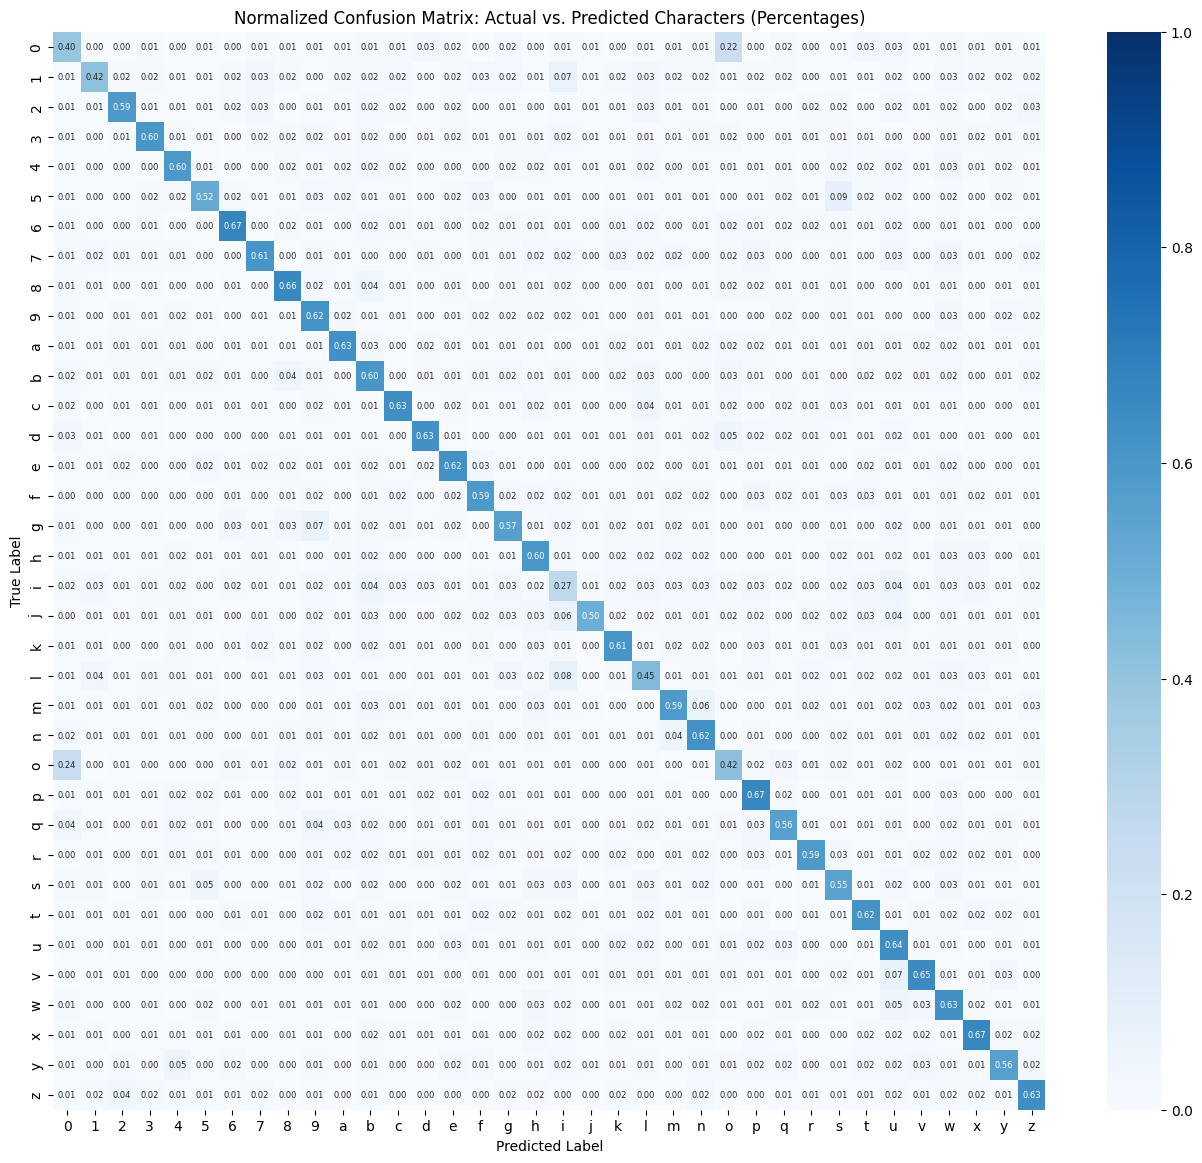

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert actual labels to numerical form if they aren't already
# Assuming y_test contains string labels and cnn.char_to_idx is available
actual_labels_numerical = [cnn.char_to_idx[label.lower()] for label in y_test]
predicted_labels_numerical = [cnn.char_to_idx[char.lower()] if char.lower() in cnn.char_to_idx else -1 for char in predicted_labels]

# Filter out entries where predicted_label is -1 (unknown character)
valid_indices = [i for i, pred_num in enumerate(predicted_labels_numerical) if pred_num != -1]
actual_labels_numerical_filtered = [actual_labels_numerical[i] for i in valid_indices]
predicted_labels_numerical_filtered = [predicted_labels_numerical[i] for i in valid_indices]

# Compute confusion matrix
cm = confusion_matrix(actual_labels_numerical_filtered, predicted_labels_numerical_filtered, labels=list(range(len(cnn.charset))))

# Normalize the confusion matrix by dividing each row by its sum
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix as a heatmap
plt.figure(figsize=(16, 14)) # Increased figure size
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=cnn.charset, yticklabels=cnn.charset,
            annot_kws={"size": 6}, vmin=0.0, vmax=1.0) # Added vmin and vmax for consistent scaling
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix: Actual vs. Predicted Characters (Percentages)')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Assuming cm (confusion matrix) and y_test (actual labels) are available from previous steps
# Assuming predicted_labels (predicted labels as strings) is available

# Convert string labels to numerical labels using the cnn object's mapping
# Ensure that predicted_labels_numerical is generated correctly, handling potential unknown chars
actual_labels_numerical = [cnn.char_to_idx[label.lower()] for label in y_test]
predicted_labels_numerical = [cnn.char_to_idx[char.lower()] if char.lower() in cnn.char_to_idx else -1 for char in predicted_labels]

# Filter out entries where predicted_label is -1 (unknown character)
valid_indices = [i for i, pred_num in enumerate(predicted_labels_numerical) if pred_num != -1]
actual_labels_numerical_filtered = [actual_labels_numerical[i] for i in valid_indices]
predicted_labels_numerical_filtered = [predicted_labels_numerical[i] for i in valid_indices]
target_names = list(cnn.charset) # Get the list of character names in order

# Calculate and print precision, recall, and F1-score for each class
# Use zero_division='warn' or '0' to handle classes with no predicted samples
report = classification_report(
    actual_labels_numerical_filtered,
    predicted_labels_numerical_filtered,
    labels=list(range(len(cnn.charset))), # Ensure all possible labels are included
    target_names=target_names,
    zero_division='warn' # Or '0' to show 0.00 instead of warning
)

print("Classification Report (Precision, Recall, F1-Score per class):\n")
print(report)

Classification Report (Precision, Recall, F1-Score per class):

              precision    recall  f1-score   support

           0       0.38      0.40      0.39       278
           1       0.58      0.42      0.48       257
           2       0.66      0.59      0.62       261
           3       0.66      0.60      0.63       278
           4       0.61      0.60      0.61       258
           5       0.61      0.52      0.56       257
           6       0.68      0.67      0.68       243
           7       0.65      0.61      0.63       255
           8       0.66      0.66      0.66       286
           9       0.53      0.62      0.57       280
           a       0.67      0.63      0.65       302
           b       0.48      0.60      0.54       256
           c       0.66      0.63      0.65       263
           d       0.70      0.63      0.66       280
           e       0.61      0.62      0.61       259
           f       0.58      0.59      0.59       259
           g     

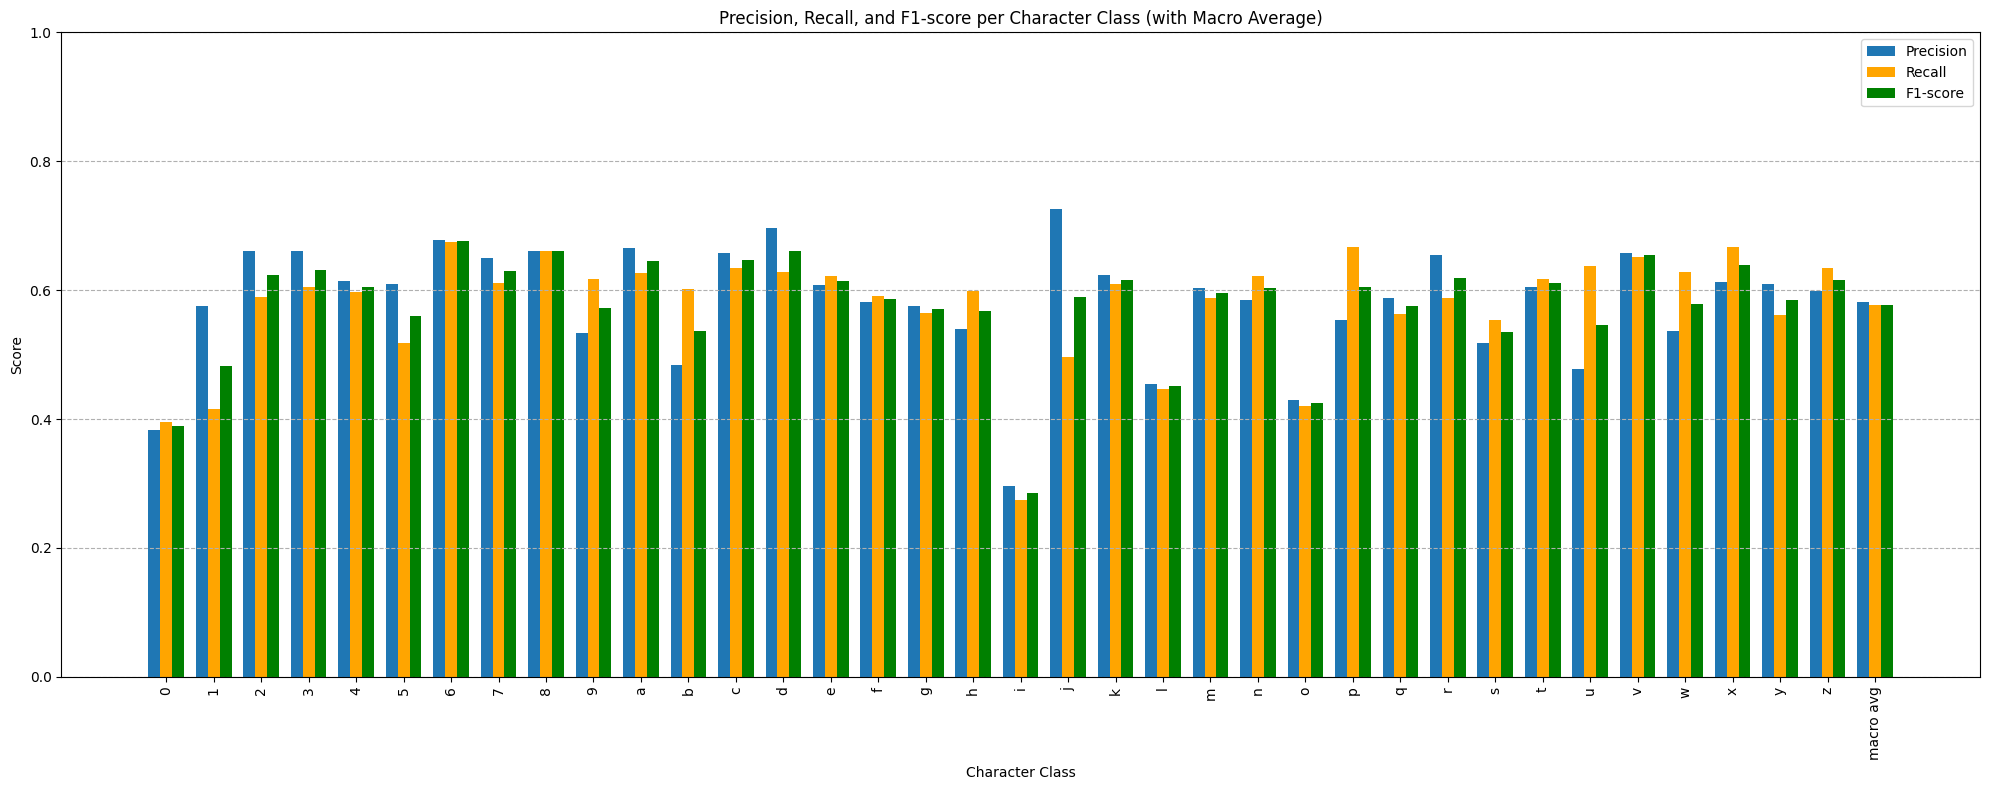

In [ ]:
# Assuming actual_labels_numerical_filtered and predicted_labels_numerical_filtered are available
# and cnn.charset is available

# Convert the report to a pandas DataFrame for easier handling
report_df = pd.DataFrame(report_dict).transpose()

# Extract overall metrics before dropping them
macro_avg_precision = report_df.loc['macro avg', 'precision']
macro_avg_recall = report_df.loc['macro avg', 'recall']
macro_avg_f1 = report_df.loc['macro avg', 'f1-score']


# Remove the overall metrics (accuracy, macro avg, weighted avg) if they exist in the index
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Add macro average as a new 'class'
report_df.loc['macro avg'] = [macro_avg_precision, macro_avg_recall, macro_avg_f1, report_dict['macro avg']['support']] # Add nan for support

# Extract precision, recall, and f1-score
precision_values = report_df['precision']
recall_values = report_df['recall']
f1_values = report_df['f1-score']
labels = report_df.index

# Plotting Precision, Recall, and F1-score per Class (Grouped Bar Chart)
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars (adjusted for 3 bars)

fig, ax = plt.subplots(figsize=(20, 8)) # Increased figure size

rects1 = ax.bar(x - width, precision_values, width, label='Precision')
rects2 = ax.bar(x, recall_values, width, label='Recall', color='orange')
rects3 = ax.bar(x + width, f1_values, width, label='F1-score', color='green')

# Add some text for labels, title and axes ticks
ax.set_xlabel("Character Class")
ax.set_ylabel("Score")
ax.set_title("Precision, Recall, and F1-score per Character Class (with Macro Average)")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(0, 1) # Ensure y-axis is between 0 and 1
ax.legend()

# Add value labels on top of bars (optional, can make chart cluttered)
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.2f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=7)

# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)


plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
#print(BLACK_LINES_REMOVED_DIR)
#characters = segment_into_characters(BLACK_LINES_REMOVED_DIR)


In [ ]:
# for result in characters[:20]:

#     # Get the data from the dictionary
#     filename = result['filename']
#     original_bgr = result['original_image']
#     crops_list = result['crops']

#     print(f"\n--- Results for: {filename} ---")
#     print(f"Found {len(crops_list)} crops.")

#     # --- 1. Display the Original Image ---
#     original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(original_rgb)
#     plt.title(f"Original Image: {filename}", fontsize=16)
#     plt.axis('off')
#     plt.show()

#     # --- 2. Display all its Crops in a Grid ---
#     if not crops_list:
#         print("No crops found for this image.")
#         continue

#     # Calculate grid size (e.g., max 5 columns)
#     num_crops = len(crops_list)
#     cols = min(num_crops, 5)
#     rows = int(np.ceil(num_crops / cols))

#     # Create the figure for the grid
#     plt.figure(figsize=(cols * 3, rows * 3))
#     plt.suptitle(f"Crops from: {filename}", fontsize=14)

#     # Loop over the crops and add them to the grid
#     for i, crop_bgr in enumerate(crops_list):
#         # Convert crop to RGB for display
#         crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

#         # Add a new subplot to the grid
#         ax = plt.subplot(rows, cols, i + 1)
#         ax.imshow(crop_rgb)
#         ax.set_title(f"Crop {i+1}")
#         ax.axis('off')

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

In [ ]:
characters1 = transform_resolve_thin_characters(characters)

In [ ]:
characters2 = deskew_characters(characters1)
#characters3 = smoothen_edges(characters2)

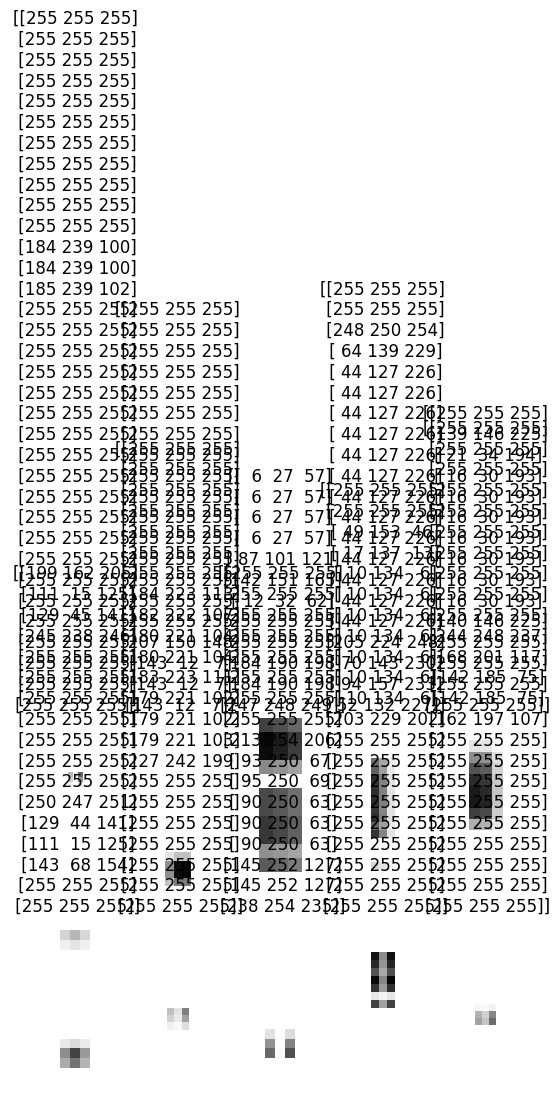

In [ ]:
# plot the first 10 characters
offset = 0
characters_to_show = characters
for i in range(offset, offset + 10):
    plt.subplot(2, 5, i - offset + 1)
    plt.imshow(cv2.cvtColor(characters_to_show[i][0], cv2.COLOR_BGR2RGB))
    plt.title(characters_to_show[i][1])
    plt.axis("off")
plt.show()

## TODO, ACTUAL DEADLINE: 15/11/2025
1. try actual architecture to convert faster, tidy up by reading from directory (youngseo)
2. try using A100
3. benchmark segmentation before contrast enhancement to see if it is better (justin)
4. continue on GAN (bryan)
5. continue on cnn + rnn that takes in whole image and predict (hejin)
6. add function to add padding (scale up until one side hits 80, add padding to the other side, keep aspect ratio the same) and add function to grayscale the characters before saving to folder (justin)
7. try transformer (chun man)
7. start on poster
\